In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests

%matplotlib inline

In [2]:
csvpath = Path("../Data/GNRC.csv")
stock_title = "Generac Holdings Inc. Stock Price Prediction Model"

In [3]:
stock_df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
stock_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-25,$396.05,1564381,$397.78,$400.64,$391.01
2021-06-24,$392.62,1110238,$409.28,$409.38,$390.16
2021-06-23,$406.12,869092,$400,$407.70,$397.04
2021-06-22,$396.77,833740,$389.21,$399.58,$388.21
2021-06-21,$389.21,890232,$387,$390.56,$376.42


In [5]:
stock_df.sort_index(ascending=True, inplace=True)

In [6]:
stock_df = stock_df.rename(columns={"Close/Last": "Close"})

In [7]:
stock_df = stock_df[['Close']]
stock_df

,Close
Date,
2011-06-27,$19.25
2011-06-28,$19.31
2011-06-29,$19.29
2011-06-30,$19.40
2011-07-01,$19.62
...,...
2021-06-21,$389.21
2021-06-22,$396.77
2021-06-23,$406.12


In [8]:
stock_df['Close'] = stock_df['Close'].str.replace('$', '').astype(float)

In [9]:
stock_df

,Close
Date,
2011-06-27,19.25
2011-06-28,19.31
2011-06-29,19.29
2011-06-30,19.40
2011-07-01,19.62
...,...
2021-06-21,389.21
2021-06-22,396.77
2021-06-23,406.12


In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
window_size = 100
feature_column = 0 # why 0?
target_column = 0 # Why 0?

X, y = window_data(stock_df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[19.25 19.31 19.29 19.4  19.62 19.52 19.51 19.55 19.7  19.28 19.3  19.81
  19.42 19.76 19.26 19.86 20.06 20.65 20.42 20.36 19.38 18.76 18.75 18.55
  18.6  18.25 18.41 17.36 18.56 16.71 18.05 17.05 18.06 18.51 19.47 19.2
  18.63 17.31 16.52 17.15 18.76 19.23 19.45 20.31 20.5  20.27 20.61 20.27
  19.35 19.17 19.43 19.1  18.7  18.67 18.8  18.63 18.81 18.6  18.55 18.41
  17.31 15.73 15.57 18.59 18.28 17.67 18.19 18.81 18.62 19.59 19.79 20.9
  20.09 21.36 20.91 20.77 20.72 21.44 20.68 21.23 21.06 21.   21.32 21.79
  20.8  21.38 22.18 22.1  22.86 23.23 23.92 24.73 24.1  24.13 25.17 24.89
  24.96 25.19 24.64 24.45]
 [19.31 19.29 19.4  19.62 19.52 19.51 19.55 19.7  19.28 19.3  19.81 19.42
  19.76 19.26 19.86 20.06 20.65 20.42 20.36 19.38 18.76 18.75 18.55 18.6
  18.25 18.41 17.36 18.56 16.71 18.05 17.05 18.06 18.51 19.47 19.2  18.63
  17.31 16.52 17.15 18.76 19.23 19.45 20.31 20.5  20.27 20.61 20.27 19.35
  19.17 19.43 19.1  18.7  18.67 18.8  18.63 18.81 18.6  18.55 18.41 17.

In [12]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
y_train

array([[23.76],
       [23.61],
       [23.9 ],
       ...,
       [36.35],
       [36.41],
       [36.68]])

In [14]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [15]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [18]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [19]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 12s 402ms/step - loss: 0.0121
Epoch 2/20
15/15 [==============================] - 6s 397ms/step - loss: 0.0162
Epoch 3/20
15/15 [==============================] - 7s 436ms/step - loss: 0.0203
Epoch 4/20
15/15 [==============================] - 6s 405ms/step - loss: 0.0223
Epoch 5/20
15/15 [==============================] - 6s 404ms/step - loss: 0.0208
Epoch 6/20
15/15 [==============================] - 6s 399ms/step - loss: 0.0141
Epoch 7/20
15/15 [==============================] - 6s 396ms/step - loss: 0.0058
Epoch 8/20
15/15 [==============================] - 6s 396ms/step - loss: 0.0047
Epoch 9/20
15/15 [==============================] - 6s 403ms/step - loss: 0.0042
Epoch 10/20
15/15 [==============================] - 6s 399ms/step - loss: 0.0064
Epoch 11/20
15/15 [==============================] - 6s 386ms/step - loss: 0.0056
Epoch 12/20
15/15 [==============================] - 6s 388ms/step - loss: 0.0037
Epoch 13/20
15/15 [=====

In [20]:
model.evaluate(X_test, y_test, verbose=0)

2.468395709991455

In [21]:
predicted = model.predict(X_test)

In [22]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [23]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
stock_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = stock_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stock_actual_predicted.head()

,Actual,Predicted
Date,,
2017-08-23,37.24,36.437511
2017-08-24,36.19,36.328259
2017-08-25,37.70,36.211845
2017-08-28,38.59,36.125099
2017-08-29,38.06,36.101730


In [25]:
stock_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-21,386.40,153.484344
2021-06-22,389.21,153.752594
2021-06-23,396.77,154.018631
2021-06-24,406.12,154.282623
2021-06-25,392.62,154.546463


<AxesSubplot:title={'center':'Generac Holdings Inc. Stock Price Prediction Model'}, xlabel='Date', ylabel='Price'>

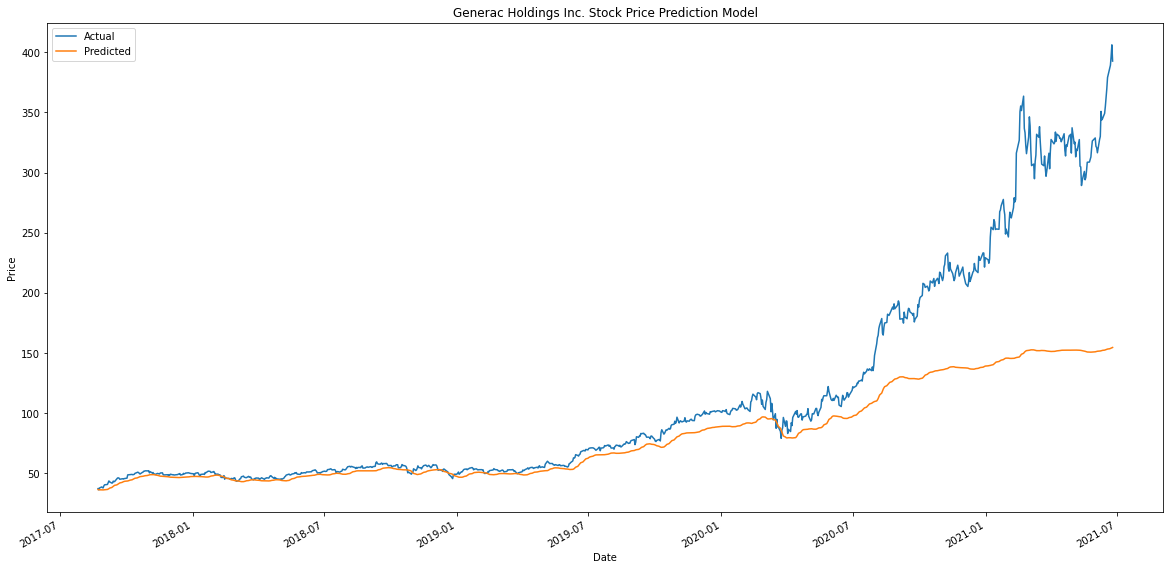

In [26]:
stock_actual_predicted.plot(figsize=(20,10), ylabel="Price", title=stock_title)